On this page, we will have a closer look at tokenization.

As we saw in the preprocessing tutorial, tokenizing a text is splitting it into words or subwords, which then are converted to ids through a look-up table. Converting words or subwords to ids is straightforward, so in this summary, we will focus on splitting a text into words or subwords (i.e. tokenizing a text). More specifically, we will look at the three main types of tokenizers used in 🤗 Transformers: Byte-Pair Encoding (BPE), WordPiece, and SentencePiece, and show examples of which tokenizer type is used by which model.

Note that on each model page, you can look at the documentation of the associated tokenizer to know which tokenizer type was used by the pretrained model. For instance, if we look at BertTokenizer, we can see that the model uses WordPiece.

 Introduction

Splitting a text into smaller chunks is a task that is harder than it looks, and there are multiple ways of doing so. For instance, let’s look at the sentence "Don't you love 🤗 Transformers? We sure do."

A simple way of tokenizing this text is to split it by spaces, which would give:

In [ ]:
["Don't", "you", "love", "🤗", "Transformers?", "We", "sure", "do."]

This is a sensible first step, but if we look at the tokens "Transformers?" and "do.", we notice that the punctuation is attached to the words "Transformer" and "do", which is suboptimal. We should take the punctuation into account so that a model does not have to learn a different representation of a word and every possible punctuation symbol that could follow it, which would explode the number of representations the model has to learn. Taking punctuation into account, tokenizing our exemplary text would give:

In [ ]:
["Don", "'", "t", "you", "love", "🤗", "Transformers", "?", "We", "sure", "do", "."]

Better. However, it is disadvantageous, how the tokenization dealt with the word "Don't". "Don't" stands for "do not", so it would be better tokenized as ["Do", "n't"]. This is where things start getting complicated, and part of the reason each model has its own tokenizer type. Depending on the rules we apply for tokenizing a text, a different tokenized output is generated for the same text. A pretrained model only performs properly if you feed it an input that was tokenized with the same rules that were used to tokenize its training data.

spaCy and Moses are two popular rule-based tokenizers. Applying them on our example, spaCy and Moses would output something like:

In [ ]:
["Do", "n't", "you", "love", "🤗", "Transformers", "?", "We", "sure", "do", "."]

As can be seen space and punctuation tokenization, as well as rule-based tokenization, is used here. Space and punctuation tokenization and rule-based tokenization are both examples of word tokenization, which is loosely defined as splitting sentences into words. While it’s the most intuitive way to split texts into smaller chunks, this tokenization method can lead to problems for massive text corpora. In this case, space and punctuation tokenization usually generates a very big vocabulary (the set of all unique words and tokens used). E.g., Transformer XL uses space and punctuation tokenization, resulting in a vocabulary size of 267,735!

Such a big vocabulary size forces the model to have an enormous embedding matrix as the input and output layer, which causes both an increased memory and time complexity. In general, transformers models rarely have a vocabulary size greater than 50,000, especially if they are pretrained only on a single language.

So if simple space and punctuation tokenization is unsatisfactory, why not simply tokenize on characters?

As can be seen space and punctuation tokenization, as well as rule-based tokenization, is used here. Space and punctuation tokenization and rule-based tokenization are both examples of word tokenization, which is loosely defined as splitting sentences into words. While it’s the most intuitive way to split texts into smaller chunks, this tokenization method can lead to problems for massive text corpora. In this case, space and punctuation tokenization usually generates a very big vocabulary (the set of all unique words and tokens used). E.g., Transformer XL uses space and punctuation tokenization, resulting in a vocabulary size of 267,735!

Such a big vocabulary size forces the model to have an enormous embedding matrix as the input and output layer, which causes both an increased memory and time complexity. In general, transformers models rarely have a vocabulary size greater than 50,000, especially if they are pretrained only on a single language.

So if simple space and punctuation tokenization is unsatisfactory, why not simply tokenize on characters?

 Subword tokenization

Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords. For instance "annoyingly" might be considered a rare word and could be decomposed into "annoying" and "ly". Both "annoying" and "ly" as stand-alone subwords would appear more frequently while at the same time the meaning of "annoyingly" is kept by the composite meaning of "annoying" and "ly". This is especially useful in agglutinative languages such as Turkish, where you can form (almost) arbitrarily long complex words by stringing together subwords.

Subword tokenization allows the model to have a reasonable vocabulary size while being able to learn meaningful context-independent representations. In addition, subword tokenization enables the model to process words it has never seen before, by decomposing them into known subwords. For instance, the BertTokenizer tokenizes "I have a new GPU!" as follows:

In [1]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
tokenizer.tokenize("I have a new GPU!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

['i', 'have', 'a', 'new', 'gp', '##u', '!']

Because we are considering the uncased model, the sentence was lowercased first. We can see that the words ["i", "have", "a", "new"] are present in the tokenizer’s vocabulary, but the word "gpu" is not. Consequently, the tokenizer splits "gpu" into known subwords: ["gp" and "##u"]. "##" means that the rest of the token should be attached to the previous one, without space (for decoding or reversal of the tokenization).

As another example, XLNetTokenizer tokenizes our previously exemplary text as follows:

In [2]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")
tokenizer.tokenize("Don't you love 🤗 Transformers? We sure do.")

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

['▁Don',
 "'",
 't',
 '▁you',
 '▁love',
 '▁',
 '🤗',
 '▁',
 'Transform',
 'ers',
 '?',
 '▁We',
 '▁sure',
 '▁do',
 '.']

We’ll get back to the meaning of those "▁" when we look at SentencePiece. As one can see, the rare word "Transformers" has been split into the more frequent subwords "Transform" and "ers".

Let’s now look at how the different subword tokenization algorithms work. Note that all of those tokenization algorithms rely on some form of training which is usually done on the corpus the corresponding model will be trained on.
Byte-Pair Encoding (BPE)

Byte-Pair Encoding (BPE) was introduced in Neural Machine Translation of Rare Words with Subword Units (Sennrich et al., 2015). BPE relies on a pre-tokenizer that splits the training data into words. Pretokenization can be as simple as space tokenization, e.g. GPT-2, RoBERTa. More advanced pre-tokenization include rule-based tokenization, e.g. XLM, FlauBERT which uses Moses for most languages, or GPT which uses spaCy and ftfy, to count the frequency of each word in the training corpus.

After pre-tokenization, a set of unique words has been created and the frequency with which each word occurred in the training data has been determined. Next, BPE creates a base vocabulary consisting of all symbols that occur in the set of unique words and learns merge rules to form a new symbol from two symbols of the base vocabulary. It does so until the vocabulary has attained the desired vocabulary size. Note that the desired vocabulary size is a hyperparameter to define before training the tokenizer.

As an example, let’s assume that after pre-tokenization, the following set of words including their frequency has been determined:

In [ ]:
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)

Consequently, the base vocabulary is ["b", "g", "h", "n", "p", "s", "u"]. Splitting all words into symbols of the base vocabulary, we obtain:

In [ ]:
("h" "u" "g", 10), ("p" "u" "g", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "u" "g" "s", 5)

BPE then counts the frequency of each possible symbol pair and picks the symbol pair that occurs most frequently. In the example above "h" followed by "u" is present 10 + 5 = 15 times (10 times in the 10 occurrences of "hug", 5 times in the 5 occurrences of "hugs"). However, the most frequent symbol pair is "u" followed by "g", occurring 10 + 5 + 5 = 20 times in total. Thus, the first merge rule the tokenizer learns is to group all "u" symbols followed by a "g" symbol together. Next, "ug" is added to the vocabulary. The set of words then becomes

In [ ]:
("h" "ug", 10), ("p" "ug", 5), ("p" "u" "n", 12), ("b" "u" "n", 4), ("h" "ug" "s", 5)

BPE then identifies the next most common symbol pair. It’s "u" followed by "n", which occurs 16 times. "u", "n" is merged to "un" and added to the vocabulary. The next most frequent symbol pair is "h" followed by "ug", occurring 15 times. Again the pair is merged and "hug" can be added to the vocabulary.

At this stage, the vocabulary is ["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"] and our set of unique words is represented as

In [ ]:
("hug", 10), ("p" "ug", 5), ("p" "un", 12), ("b" "un", 4), ("hug" "s", 5)

Assuming, that the Byte-Pair Encoding training would stop at this point, the learned merge rules would then be applied to new words (as long as those new words do not include symbols that were not in the base vocabulary). For instance, the word "bug" would be tokenized to ["b", "ug"] but "mug" would be tokenized as ["<unk>", "ug"] since the symbol "m" is not in the base vocabulary. In general, single letters such as "m" are not replaced by the "<unk>" symbol because the training data usually includes at least one occurrence of each letter, but it is likely to happen for very special characters like emojis.

As mentioned earlier, the vocabulary size, i.e. the base vocabulary size + the number of merges, is a hyperparameter to choose. For instance GPT has a vocabulary size of 40,478 since they have 478 base characters and chose to stop training after 40,000 merges.

 Byte-level BPE

A base vocabulary that includes all possible base characters can be quite large if e.g. all unicode characters are considered as base characters. To have a better base vocabulary, GPT-2 uses bytes as the base vocabulary, which is a clever trick to force the base vocabulary to be of size 256 while ensuring that every base character is included in the vocabulary. With some additional rules to deal with punctuation, the GPT2’s tokenizer can tokenize every text without the need for the <unk> symbol. GPT-2 has a vocabulary size of 50,257, which corresponds to the 256 bytes base tokens, a special end-of-text token and the symbols learned with 50,000 merges.

 WordPiece

WordPiece is the subword tokenization algorithm used for BERT, DistilBERT, and Electra. The algorithm was outlined in Japanese and Korean Voice Search (Schuster et al., 2012) and is very similar to BPE. WordPiece first initializes the vocabulary to include every character present in the training data and progressively learns a given number of merge rules. In contrast to BPE, WordPiece does not choose the most frequent symbol pair, but the one that maximizes the likelihood of the training data once added to the vocabulary.

So what does this mean exactly? Referring to the previous example, maximizing the likelihood of the training data is equivalent to finding the symbol pair, whose probability divided by the probabilities of its first symbol followed by its second symbol is the greatest among all symbol pairs. E.g. "u", followed by "g" would have only been merged if the probability of "ug" divided by "u", "g" would have been greater than for any other symbol pair. Intuitively, WordPiece is slightly different to BPE in that it evaluates what it loses by merging two symbols to ensure it’s worth it.

Unigram

Unigram is a subword tokenization algorithm introduced in Subword Regularization: Improving Neural Network Translation Models with Multiple Subword Candidates (Kudo, 2018). In contrast to BPE or WordPiece, Unigram initializes its base vocabulary to a large number of symbols and progressively trims down each symbol to obtain a smaller vocabulary. The base vocabulary could for instance correspond to all pre-tokenized words and the most common substrings. Unigram is not used directly for any of the models in the transformers, but it’s used in conjunction with SentencePiece.

At each training step, the Unigram algorithm defines a loss (often defined as the log-likelihood) over the training data given the current vocabulary and a unigram language model. Then, for each symbol in the vocabulary, the algorithm computes how much the overall loss would increase if the symbol was to be removed from the vocabulary. Unigram then removes p (with p usually being 10% or 20%) percent of the symbols whose loss increase is the lowest, i.e. those symbols that least affect the overall loss over the training data. This process is repeated until the vocabulary has reached the desired size. The Unigram algorithm always keeps the base characters so that any word can be tokenized.

Because Unigram is not based on merge rules (in contrast to BPE and WordPiece), the algorithm has several ways of tokenizing new text after training. As an example, if a trained Unigram tokenizer exhibits the vocabulary:

In [ ]:
["b", "g", "h", "n", "p", "s", "u", "ug", "un", "hug"],

"hugs" could be tokenized both as ["hug", "s"], ["h", "ug", "s"] or ["h", "u", "g", "s"]. So which one to choose? Unigram saves the probability of each token in the training corpus on top of saving the vocabulary so that the probability of each possible tokenization can be computed after training. The algorithm simply picks the most likely tokenization in practice, but also offers the possibility to sample a possible tokenization according to their probabilities.

Those probabilities are defined by the loss the tokenizer is trained on. Assuming that the training data consists of the wordsx1,…,xNx1​,…,xN​ and that the set of all possible tokenizations for a wordxixi​ is defined asS(xi)S(xi​), then the overall loss is defined as

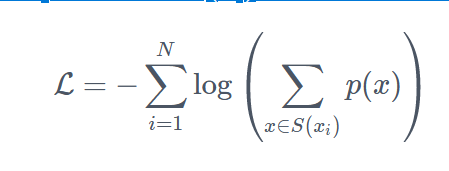

 SentencePiece

All tokenization algorithms described so far have the same problem: It is assumed that the input text uses spaces to separate words. However, not all languages use spaces to separate words. One possible solution is to use language specific pre-tokenizers, e.g. XLM uses a specific Chinese, Japanese, and Thai pre-tokenizer). To solve this problem more generally, SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing (Kudo et al., 2018) treats the input as a raw input stream, thus including the space in the set of characters to use. It then uses the BPE or unigram algorithm to construct the appropriate vocabulary.

The XLNetTokenizer uses SentencePiece for example, which is also why in the example earlier the "▁" character was included in the vocabulary. Decoding with SentencePiece is very easy since all tokens can just be concatenated and "▁" is replaced by a space.

All transformers models in the library that use SentencePiece use it in combination with unigram. Examples of models using SentencePiece are ALBERT, XLNet, Marian, and T5.